In [5]:
import pandas as pd

# прочитаем метаданные по всем трекам с колонкой жанра
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')

# прочитаем метрику с признаками, по которым будем классифицировать
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float = True)

# объединим необходимые колонки из tracks и метрику в одном датасете
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')


echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [ ]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


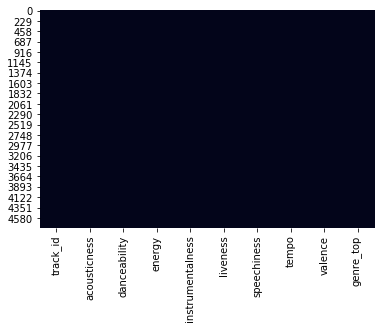

In [ ]:
# проверяем missing values
import seaborn as sns
sns.heatmap(echo_tracks.isnull(), cbar=False)

In [ ]:
# делаем корреляционную матрицу
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


In [ ]:
# определяем признаки
features = echo_tracks.drop(columns =['genre_top', 'track_id'], axis=1)

# определяем таргет
labels = echo_tracks['genre_top']

from sklearn.preprocessing import StandardScaler

# стандартизируем признаки
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

Explained variance ratio : 
[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


Number of components = 8


Text(0.5, 0, 'PCA')

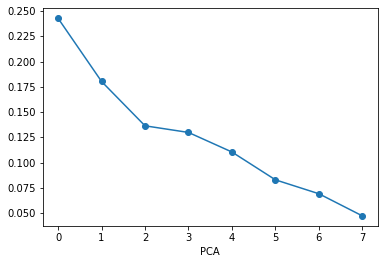

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

print("Explained variance ratio : \n{}".format(pca.explained_variance_ratio_))
print("\n")
print("Number of components = {}".format(pca.n_components_))  


fig, ax = plt.subplots()
ax.plot(range(8), exp_variance, marker='o')
ax.set_xlabel('PCA')


In [ ]:
print(exp_variance)

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


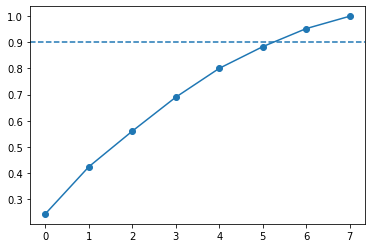

In [ ]:
import numpy as np

#строим кумулятивный график

cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(range(8), cum_exp_variance, marker='o')
ax.axhline(y=0.9, linestyle='--')
n_components = 6

#делаем PCA еще раз, но с новым количеством компонент
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)
#обучаем дерево решений
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# предсказываем таргет
pred_labels_tree = tree.predict(test_features)

In [ ]:
from sklearn.linear_model import LogisticRegression

#обучаем логистическую регрессию
logreg = LogisticRegression()
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

#создаём classification_report для обеих моделей
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# разделяем таргет отдельно на хип-хоп, отдельно на рок, чтобы сбалансировать данные
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]

# делаем рока столько же, сколько и хип-хопа
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hop_only), random_state=10)

#конкатенируем
rock_hop_bal = pd.concat([rock_only, hop_only])

features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

In [ ]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# делаем K-fold кросс-валидацию
kf = KFold(n_splits=10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur